# Deploying stocks model serving

Steps
* [Creating serving graph](#Creating-serving-graph)
* [Testing locally](#Testing-locally)
* [Deploying the serving graph](#Deploying-the-serving-graph)

In [1]:
import mlrun
import os

project = mlrun.get_or_create_project('stocks',user_project=True,context='src/')

> 2022-08-09 13:38:57,081 [info] loaded project stocks from MLRun DB


## Creating serving graph

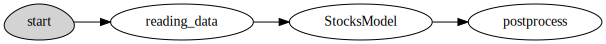

In [2]:
fn = mlrun.code_to_function('serving_stocks', kind='serving',image='mlrun/ml-models', filename='src/serving_stocks.py').apply(mlrun.auto_mount())

graph = fn.set_topology("flow", engine="async")
# Build the serving graph:
graph.to(handler='preprocess', name='reading_data')\
     .to(class_name="StocksModel", model_name='stocks_model', model_path=project.get_artifact_uri('stocks_model'))\
     .to(handler='postprocess',name='postprocess').respond()

fn.set_tracking()

fn.plot(rankdir="LR")

## Testing locally

In [3]:
server = fn.to_mock_server()

> 2022-08-09 13:39:11,279 [info] downloading v3io:///projects/stocks-dani/artifacts/train-stocks-model-handler/0/stocks_model_custom_objects_map.json.json to local temp file
> 2022-08-09 13:39:11,289 [info] downloading v3io:///projects/stocks-dani/artifacts/train-stocks-model-handler/0/stocks_model_custom_objects.zip.zip to local temp file
> 2022-08-09 13:39:19,539 [info] model StocksModel was loaded


In [4]:
import pandas as pd
response = server.test(body={"vector_name": 'stocks',
                             "start_time" : 59,
                             "end_time"   : 0,
                             "seq_size"   : 5})

pd.DataFrame(data=response[0], columns=response[1]).head()

prediction             datetime tickers        true
0  421.069590  2022-06-13 09:30:00    ADBE  433.640022
1  140.592424  2022-06-13 09:30:00     ABC  141.000000
2  109.195277  2022-06-13 09:30:00     ABT  109.140098
3    9.162683  2022-06-13 09:30:00     AAL   15.039998
4  130.826972  2022-06-13 09:30:00       A  132.470000

## Deploying the serving graph

In [5]:
address = fn.deploy()

> 2022-08-09 13:39:20,518 [info] Starting remote function deploy
2022-08-09 13:39:22  (info) Deploying function
2022-08-09 13:39:22  (info) Building
2022-08-09 13:39:22  (info) Staging files and preparing base images
2022-08-09 13:39:22  (info) Building processor image
2022-08-09 13:41:40  (info) Build complete
2022-08-09 13:42:00  (info) Function deploy complete
> 2022-08-09 13:42:01,832 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-serving-stocks.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-serving-stocks-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}


In [6]:
import json
response = fn.invoke(path=address,
                     body={"vector_name": 'stocks',
                           "start_time" : 59,
                           "end_time"   : 0,
                           "seq_size"   : 5})

pd.DataFrame(data=response[0], columns=response[1])

> 2022-08-09 13:42:01,898 [info] invoking function: {'method': 'POST', 'path': 'http://stocks-dani-serving-stocks-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/'}


prediction             datetime tickers        true
0  421.069590  2022-06-13 09:30:00    ADBE  433.640022
1  140.592424  2022-06-13 09:30:00     ABC  141.000000
2  109.195277  2022-06-13 09:30:00     ABT  109.140098
3    9.162683  2022-06-13 09:30:00     AAL   15.039998
4  130.826966  2022-06-13 09:30:00       A  132.470000
5  306.482900  2022-06-13 09:30:00     ACN  310.109990
6  140.398811  2022-06-13 09:30:00    ABBV  140.300004
7  195.182948  2022-06-13 09:30:00     AAP  194.750000
8  164.991457  2022-06-13 09:30:00    AAPL  165.029999
9  290.234253  2022-06-13 09:30:00    ABMD  293.309998